In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent
from rl_equation_solver.utilities.utilities import build_adjacency_matrix
from rl_equation_solver.agent.networks import GCN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
import networkx as nx
import numpy as np
from torch_geometric.utils.convert import from_networkx
import matplotlib.pyplot as plt
from rex import init_logger
import torch
from torch_geometric.nn import GCNConv
from torch_geometric import utils
import scipy.sparse as sp
from sklearn.decomposition import PCA

c:\Users\bbent\miniconda3\envs\rl_solver\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
init_logger(__name__, log_level='DEBUG')
init_logger('rl_equation_solver', log_level="DEBUG")

<Logger rl_equation_solver (DEBUG)>

In [30]:
def make_plot(agent, round, start=0):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    avg_complex = []
    avg_reward = []
    avg_loss = []
    for episode in list(agent.history.keys())[start:]:
        avg_complex.append(np.mean(agent.history[episode]['complexity']))
        avg_loss.append(np.nanmean(agent.history[episode]['loss']))
        avg_reward.append(np.mean(agent.history[episode]['reward']))
    
    y = moving_avg(avg_complex, 1)
    x = np.arange(len(y))
    a, b = np.polyfit(x, y, 1)
    ax[0].scatter(x, y)
    ax[0].plot(x, a*x+b, color='red')

    y = moving_avg(avg_loss, 1)
    x = np.arange(len(y))
    a, b = np.polyfit(x, y, 1)
    ax[1].scatter(x, y)
    ax[1].plot(x, a*x+b, color='red')
    
    y = moving_avg(avg_reward, 1)
    x = np.arange(len(y))
    a, b = np.polyfit(x, y, 1)
    ax[2].scatter(x, y)
    ax[2].plot(x, a*x+b, color='red')
    
    ax[0].set_title('Complexity')
    ax[1].set_title('Loss')
    ax[2].set_title("Reward")
    plt.annotate('Episode', (0.4, 0.01), xycoords='figure fraction')
    fig.suptitle(f'Round {round}')
    fig.savefig(f'./figs/round_{round}.png', dpi=300)

In [6]:
def moving_avg(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [17]:
env = Env(order=2)

In [33]:
agent = AgentGCN(env)

INFO - 2023-04-10 11:23:14,402 [gcn.py:40] : Initialized Agent with device cpu


INFO - 2023-04-10 11:23:16,028 [base.py:224] : episode 0, {'complexity': 13, 'loss': nan, 'reward': '7.143e-02', 'state': 1 - a0}
INFO - 2023-04-10 11:23:16,048 [base.py:224] : episode 0, {'complexity': 1, 'loss': nan, 'reward': '5.000e-01', 'state': (1 - a0)/a1}
INFO - 2023-04-10 11:23:16,064 [base.py:224] : episode 0, {'complexity': 1, 'loss': nan, 'reward': '5.000e-01', 'state': (1 - a0)/a1}
INFO - 2023-04-10 11:23:16,110 [base.py:224] : episode 0, {'complexity': 9, 'loss': nan, 'reward': '1.000e-01', 'state': (a0*a1 - a0 + 1)/a1}
INFO - 2023-04-10 11:23:16,167 [base.py:224] : episode 0, {'complexity': 15, 'loss': nan, 'reward': '6.250e-02', 'state': a0 - a0/a1 + a1 + 1/a1}
INFO - 2023-04-10 11:23:16,226 [base.py:224] : episode 0, {'complexity': 17, 'loss': nan, 'reward': '5.556e-02', 'state': (-a0 + a1*(2*a0 + a1) + 1)/a1}
INFO - 2023-04-10 11:23:16,333 [base.py:224] : episode 0, {'complexity': 43, 'loss': nan, 'reward': '2.273e-02', 'state': ((-a0 + a1*(2*a0 + a1) + 1)/a1)**a1}
IN

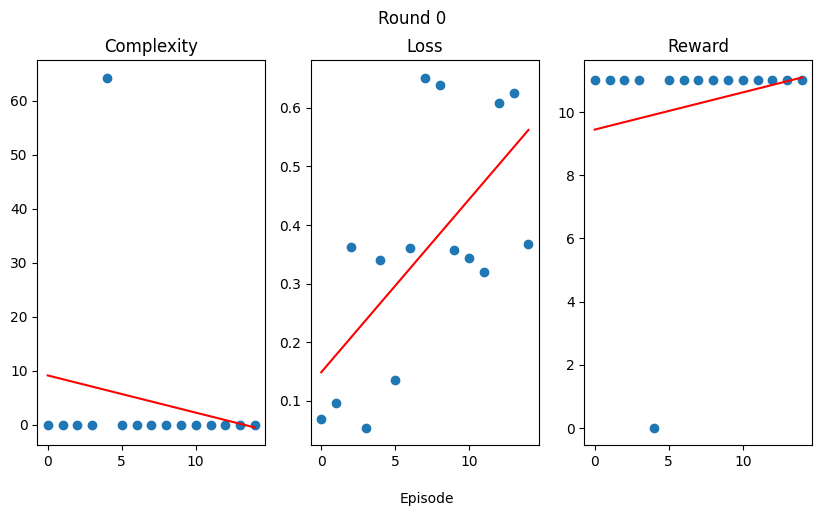

In [34]:

for i in range(1):
    agent.train(num_episodes=20)
    make_plot(agent, round=i, start=5)    

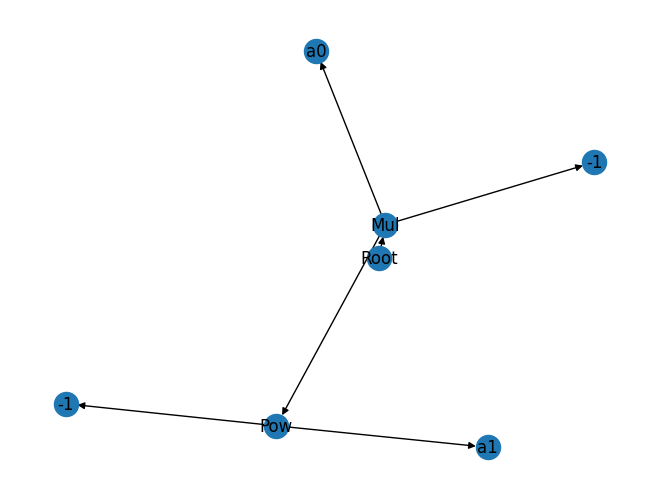

In [10]:
nx.draw(env.state_graph, labels=env.node_labels)